<a href="https://colab.research.google.com/github/jagatabhay/TSAI/blob/master/S12/TinyImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget cq http://cs231n.stanford.edu/tiny-imagenet-200.zip

import zipfile
with zipfile.ZipFile('tiny-imagenet-200.zip','r') as my_zip:
     my_zip.extractall()

--2020-06-28 02:03:28--  http://cq/
Resolving cq (cq)... failed: Name or service not known.
wget: unable to resolve host address ‘cq’
--2020-06-28 02:03:28--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  19.8MB/s    in 16s     

2020-06-28 02:03:44 (15.2 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

FINISHED --2020-06-28 02:03:44--
Total wall clock time: 16s
Downloaded: 1 files, 237M in 16s (15.2 MB/s)


In [2]:
!git clone https://github.com/jagatabhay/TSAI.git

Cloning into 'TSAI'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 565 (delta 8), reused 0 (delta 0), pack-reused 541
Receiving objects: 100% (565/565), 4.06 MiB | 6.67 MiB/s, done.
Resolving deltas: 100% (303/303), done.


In [3]:
from TSAI.S12 import resnet
from TSAI.S12 import albumentationstransform
model , device = resnet.resnet18(num_classes = 200)

Device Load :  cuda
Class Loaded Successfully 
REQUIRED LIBRARIES LOADED...


In [4]:
import os
import shutil

os.makedirs('TinyImageNet')
os.makedirs('TinyImageNet/train')
os.makedirs('TinyImageNet/test')
os.makedirs('TinyImageNet/val')


for classes in os.listdir('tiny-imagenet-200/train'):
  os.makedirs('TinyImageNet/train/'+classes)
  for images in os.listdir('tiny-imagenet-200/train/'+classes+'/images'):
    shutil.move('tiny-imagenet-200/train/'+classes+'/images/'+images,'TinyImageNet/train/'+classes)


print('Train Data Transfer successfully')

val_class = []

for line in open('tiny-imagenet-200/val/val_annotations.txt','r'):
  img_name , class_id = line.split('\t')[:2]
  val_class.append(class_id)


val_class = list(set(val_class))


for i in val_class:
  os.makedirs(f'TinyImageNet/val/{i}')


for line in open('tiny-imagenet-200/val/val_annotations.txt','r'):
  img_name , class_id = line.split('\t')[:2]
  shutil.move(f'tiny-imagenet-200/val/images/{img_name}',f'TinyImageNet/val/{class_id}')


print('Val Data Transfer successfully')

Train Data Transfer successfully
Val Data Transfer successfully


In [5]:
from torchvision import transforms , datasets
import torch


test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.4802, 0.4481, 0.3975),
                                                          (0.2302, 0.2265, 0.2262)
                                                          )])

In [6]:
train_datasets = datasets.ImageFolder( 'TinyImageNet/train' ,transform = albumentationstransform.train_transforms() )
trainloader = torch.utils.data.DataLoader(train_datasets, 
                                          batch_size = 256 , 
                                          shuffle = True , 
                                          num_workers = 4 ,
                                          pin_memory = True)

test_datasets = datasets.ImageFolder( 'TinyImageNet/val' ,transform = test_transform )
testloader = torch.utils.data.DataLoader(test_datasets, 
                                          batch_size = 256 , 
                                          shuffle = True , 
                                          num_workers = 4 ,
                                          pin_memory = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


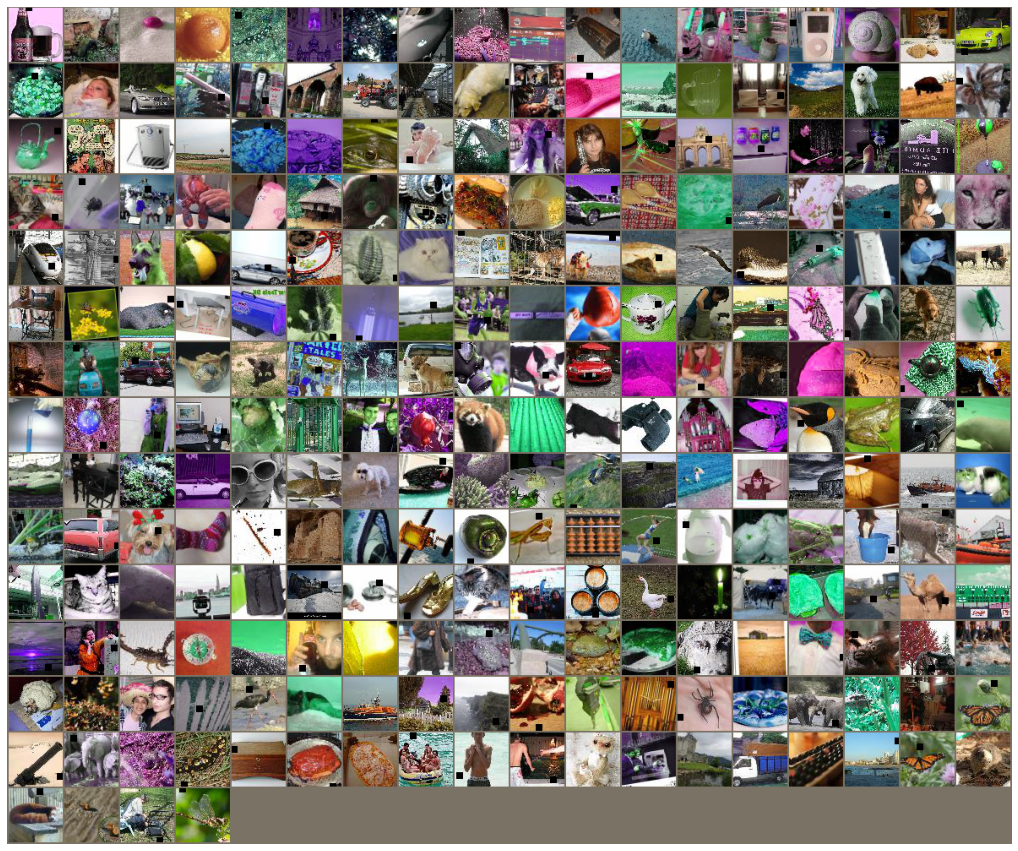

In [7]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def imshow(image):
  if isinstance(image , torch.Tensor):
    image = image.numpy().transpose(( 1, 2, 0 ))
  else:
    image = np.array(image).transpose((1 , 2, 0 ))

  #UnNormalize
  mean = np.array([0.4802, 0.4481, 0.3975])
  std = np.array([(0.2302, 0.2265, 0.2262)])
  image = std*image + mean
  
  #plot
  fig , ax = plt.subplots(1 , 1 , figsize = (18,18) )
  plt.imshow(image)
  ax.axis('off')


images , _ = next(iter(trainloader))
out = torchvision.utils.make_grid(images , nrow = 18 )
imshow(out) 

In [8]:
import torch.nn as nn 
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001 , momentum = 0.9  , weight_decay = 0.0001 )

In [9]:
for epoch in range(10):  # loop over the dataset multiple times
        
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data[0].to(device),data[1].to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            #scheduler_.step()
            
            # print statistics
            running_loss += loss.item()
            #minibatch = 50000//batchsize
            if i % 100 == 99 :    # print every 2000 mini-batches
               print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 99 ))
               running_loss = 0.0


    
print('INFO : Finished Training of Dataset ') 

[1,   100] loss: 5.294
[1,   200] loss: 5.102
[1,   300] loss: 4.921
[2,   100] loss: 4.628
[2,   200] loss: 4.504
[2,   300] loss: 4.379
[3,   100] loss: 4.170
[3,   200] loss: 4.098
[3,   300] loss: 4.039
[4,   100] loss: 3.868
[4,   200] loss: 3.849
[4,   300] loss: 3.788
[5,   100] loss: 3.655
[5,   200] loss: 3.623
[5,   300] loss: 3.589
[6,   100] loss: 3.472
[6,   200] loss: 3.459
[6,   300] loss: 3.423
[7,   100] loss: 3.323
[7,   200] loss: 3.316
[7,   300] loss: 3.272
[8,   100] loss: 3.195
[8,   200] loss: 3.156
[8,   300] loss: 3.151
[9,   100] loss: 3.077
[9,   200] loss: 3.047
[9,   300] loss: 3.027
[10,   100] loss: 2.956
[10,   200] loss: 2.949
[10,   300] loss: 2.949
INFO : Finished Training of Dataset 


In [13]:
    correct = 0
    total = 0
    with torch.no_grad():
          for data in testloader:
               images , labels = data[0].to(device) , data[1].to(device)
               output = model(images)
               _ , predicted = torch.max(output.data, 1)
               total += labels.size(0)
               correct += (predicted == labels).sum().item()
     
     
     
    print('Accuracy of the Network on the 10000 test images: %0.3f %%' % (100 * correct / total))

Accuracy of the Network on the 10000 test images: 32.490 %


In [14]:
for epoch in range(10):  # loop over the dataset multiple times
        
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data[0].to(device),data[1].to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            #scheduler_.step()
            
            # print statistics
            running_loss += loss.item()
            #minibatch = 50000//batchsize
            if i % 100 == 99 :    # print every 2000 mini-batches
               print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 99 ))
               running_loss = 0.0


    
print('INFO : Finished Training of Dataset ') 

[1,   100] loss: 2.869
[1,   200] loss: 2.861
[1,   300] loss: 2.853
[2,   100] loss: 2.753
[2,   200] loss: 2.773
[2,   300] loss: 2.772
[3,   100] loss: 2.685
[3,   200] loss: 2.672
[3,   300] loss: 2.679
[4,   100] loss: 2.606
[4,   200] loss: 2.602
[4,   300] loss: 2.587
[5,   100] loss: 2.532
[5,   200] loss: 2.547
[5,   300] loss: 2.517
[6,   100] loss: 2.464
[6,   200] loss: 2.457
[6,   300] loss: 2.431
[7,   100] loss: 2.390
[7,   200] loss: 2.398
[7,   300] loss: 2.390
[8,   100] loss: 2.331
[8,   200] loss: 2.331
[8,   300] loss: 2.337
[9,   100] loss: 2.259
[9,   200] loss: 2.281
[9,   300] loss: 2.285
[10,   100] loss: 2.227
[10,   200] loss: 2.221
[10,   300] loss: 2.216
INFO : Finished Training of Dataset 


In [15]:
    correct = 0
    total = 0
    with torch.no_grad():
          for data in testloader:
               images , labels = data[0].to(device) , data[1].to(device)
               output = model(images)
               _ , predicted = torch.max(output.data, 1)
               total += labels.size(0)
               correct += (predicted == labels).sum().item()
     
     
     
    print('Accuracy of the Network on the 10000 test images: %0.3f %%' % (100 * correct / total))

Accuracy of the Network on the 10000 test images: 42.350 %


In [16]:
for epoch in range(10):  # loop over the dataset multiple times
        
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data[0].to(device),data[1].to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            #scheduler_.step()
            
            # print statistics
            running_loss += loss.item()
            #minibatch = 50000//batchsize
            if i % 100 == 99 :    # print every 2000 mini-batches
               print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 99 ))
               running_loss = 0.0


    
print('INFO : Finished Training of Dataset ') 

[1,   100] loss: 2.167
[1,   200] loss: 2.154
[1,   300] loss: 2.170
[2,   100] loss: 2.109
[2,   200] loss: 2.115
[2,   300] loss: 2.113
[3,   100] loss: 2.046
[3,   200] loss: 2.066
[3,   300] loss: 2.059
[4,   100] loss: 1.984
[4,   200] loss: 2.017
[4,   300] loss: 2.023
[5,   100] loss: 1.957
[5,   200] loss: 1.965
[5,   300] loss: 1.968
[6,   100] loss: 1.899
[6,   200] loss: 1.914
[6,   300] loss: 1.934
[7,   100] loss: 1.861
[7,   200] loss: 1.867
[7,   300] loss: 1.887
[8,   100] loss: 1.817
[8,   200] loss: 1.808
[8,   300] loss: 1.868
[9,   100] loss: 1.760
[9,   200] loss: 1.774
[9,   300] loss: 1.804
[10,   100] loss: 1.721
[10,   200] loss: 1.737
[10,   300] loss: 1.748
INFO : Finished Training of Dataset 


In [17]:
    correct = 0
    total = 0
    with torch.no_grad():
          for data in testloader:
               images , labels = data[0].to(device) , data[1].to(device)
               output = model(images)
               _ , predicted = torch.max(output.data, 1)
               total += labels.size(0)
               correct += (predicted == labels).sum().item()
     
     
     
    print('Accuracy of the Network on the 10000 test images: %0.3f %%' % (100 * correct / total))

Accuracy of the Network on the 10000 test images: 47.280 %


In [18]:
for epoch in range(5):  # loop over the dataset multiple times
        
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data[0].to(device),data[1].to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            #scheduler_.step()
            
            # print statistics
            running_loss += loss.item()
            #minibatch = 50000//batchsize
            if i % 100 == 99 :    # print every 2000 mini-batches
               print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 99 ))
               running_loss = 0.0


    
print('INFO : Finished Training of Dataset ') 

[1,   100] loss: 1.679
[1,   200] loss: 1.696
[1,   300] loss: 1.715
[2,   100] loss: 1.627
[2,   200] loss: 1.659
[2,   300] loss: 1.671
[3,   100] loss: 1.588
[3,   200] loss: 1.611
[3,   300] loss: 1.640
[4,   100] loss: 1.563
[4,   200] loss: 1.583
[4,   300] loss: 1.587
[5,   100] loss: 1.513
[5,   200] loss: 1.552
[5,   300] loss: 1.531
INFO : Finished Training of Dataset 


In [19]:
    correct = 0
    total = 0
    with torch.no_grad():
          for data in testloader:
               images , labels = data[0].to(device) , data[1].to(device)
               output = model(images)
               _ , predicted = torch.max(output.data, 1)
               total += labels.size(0)
               correct += (predicted == labels).sum().item()
     
     
     
    print('Accuracy of the Network on the 10000 test images: %0.3f %%' % (100 * correct / total))

Accuracy of the Network on the 10000 test images: 49.100 %


In [20]:
for epoch in range(5):  # loop over the dataset multiple times
        
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data[0].to(device),data[1].to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            #scheduler_.step()
            
            # print statistics
            running_loss += loss.item()
            #minibatch = 50000//batchsize
            if i % 100 == 99 :    # print every 2000 mini-batches
               print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 99 ))
               running_loss = 0.0


    
print('INFO : Finished Training of Dataset ') 

[1,   100] loss: 1.487
[1,   200] loss: 1.500
[1,   300] loss: 1.503
[2,   100] loss: 1.435
[2,   200] loss: 1.468
[2,   300] loss: 1.487
[3,   100] loss: 1.400
[3,   200] loss: 1.434
[3,   300] loss: 1.436
[4,   100] loss: 1.350
[4,   200] loss: 1.386
[4,   300] loss: 1.419
[5,   100] loss: 1.325
[5,   200] loss: 1.364
[5,   300] loss: 1.366
INFO : Finished Training of Dataset 


In [21]:
    correct = 0
    total = 0
    with torch.no_grad():
          for data in testloader:
               images , labels = data[0].to(device) , data[1].to(device)
               output = model(images)
               _ , predicted = torch.max(output.data, 1)
               total += labels.size(0)
               correct += (predicted == labels).sum().item()
     
     
     
    print('Accuracy of the Network on the 10000 test images: %0.3f %%' % (100 * correct / total))

Accuracy of the Network on the 10000 test images: 49.470 %
